In [1]:
import xgboost as xgb
import os
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
from tabulate import tabulate
import matplotlib.pyplot as plt

import sklearn
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
women=pd.read_csv('women_atp_combine1.csv')
men=pd.read_csv('men_atp_combine1.csv')

In [3]:
women = women.drop(columns=['tourney_id', 'tourney_name', 'winner_ioc', 'winner_name', 'loser_name','loser_ioc', 'best_of', 'round'], axis=1)
women.rename(columns={'loser_tpoic':'loser_topic'}, inplace = True)

w_winner = pd.get_dummies(women, columns=['winner_topic', 'loser_topic', 'surface', 'tourney_level', 'winner_hand', 'loser_hand'])
w_winner[['winner_topic_0.0', 'winner_topic_1.0', 'winner_topic_2.0','winner_topic_3.0', 'winner_topic_4.0', 'winner_topic_5.0','winner_topic_6.0', 
         'loser_topic_0.0', 'loser_topic_1.0','loser_topic_2.0', 'loser_topic_3.0', 'loser_topic_4.0','loser_topic_5.0', 'loser_topic_6.0']]

,winner_topic_0.0,winner_topic_1.0,winner_topic_2.0,winner_topic_3.0,winner_topic_4.0,winner_topic_5.0,winner_topic_6.0,loser_topic_0.0,loser_topic_1.0,loser_topic_2.0,loser_topic_3.0,loser_topic_4.0,loser_topic_5.0,loser_topic_6.0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29632,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29633,0,0,0,0,0,0,0,0,1,0,0,0,0,0
29634,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29635,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
w_winner.columns 

Index(['Unnamed: 0', 'draw_size', 'tourney_date', 'match_num', 'winner_id',
       'winner_ht', 'winner_age', 'loser_id', 'loser_ht', 'loser_age', 'score',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_bpSaved', 'l_bpFaced', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'winner_topic_0.0', 'winner_topic_1.0', 'winner_topic_2.0',
       'winner_topic_3.0', 'winner_topic_4.0', 'winner_topic_5.0',
       'winner_topic_6.0', 'loser_topic_0.0', 'loser_topic_1.0',
       'loser_topic_2.0', 'loser_topic_3.0', 'loser_topic_4.0',
       'loser_topic_5.0', 'loser_topic_6.0', 'surface_Carpet', 'surface_Clay',
       'surface_Grass', 'surface_Hard', 'tourney_level_D', 'tourney_level_F',
       'tourney_level_G', 'tourney_level_I', 'tourney_level_O',
       'tourney_level_P', 'tourney_level_PM', 'tourney_level_W',
       'winner_hand

In [5]:
w_loser = w_winner.copy()
w_loser.columns = ['Unnamed: 0', 'draw_size', 'tourney_date', 'match_num', 'loser_id', 'loser_ht', 'loser_age','winner_id',
       'winner_ht', 'winner_age',  'score','l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_bpSaved', 'l_bpFaced',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_bpSaved', 'w_bpFaced', 'loser_rank', 'loser_rank_points', 'winner_rank',
       'winner_rank_points', 'loser_topic_0.0', 'loser_topic_1.0',
       'loser_topic_2.0', 'loser_topic_3.0', 'loser_topic_4.0',
       'loser_topic_5.0', 'loser_topic_6.0',
       'winner_topic_0.0', 'winner_topic_1.0', 'winner_topic_2.0',
       'winner_topic_3.0', 'winner_topic_4.0', 'winner_topic_5.0',
       'winner_topic_6.0', 'surface_Carpet', 'surface_Clay',
       'surface_Grass', 'surface_Hard', 'tourney_level_D', 'tourney_level_F',
       'tourney_level_G', 'tourney_level_I', 'tourney_level_O',
       'tourney_level_P', 'tourney_level_PM', 'tourney_level_W', 'loser_hand_L',
       'loser_hand_R', 'loser_hand_U',
       'winner_hand_L', 'winner_hand_R', 'winner_hand_U']
w_loser['score'] = -w_loser['score']
w_loser = w_loser[['Unnamed: 0', 'draw_size', 'tourney_date', 'match_num', 'winner_id',
       'winner_ht', 'winner_age', 'loser_id', 'loser_ht', 'loser_age', 'score',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_bpSaved', 'l_bpFaced', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'winner_topic_0.0', 'winner_topic_1.0', 'winner_topic_2.0',
       'winner_topic_3.0', 'winner_topic_4.0', 'winner_topic_5.0',
       'winner_topic_6.0', 'loser_topic_0.0', 'loser_topic_1.0',
       'loser_topic_2.0', 'loser_topic_3.0', 'loser_topic_4.0',
       'loser_topic_5.0', 'loser_topic_6.0', 'surface_Carpet', 'surface_Clay',
       'surface_Grass', 'surface_Hard', 'tourney_level_D', 'tourney_level_F',
       'tourney_level_G', 'tourney_level_I', 'tourney_level_O',
       'tourney_level_P', 'tourney_level_PM', 'tourney_level_W',
       'winner_hand_L', 'winner_hand_R', 'winner_hand_U', 'loser_hand_L',
       'loser_hand_R', 'loser_hand_U']]
w_winner=pd.concat([w_winner,w_loser],axis=0)
w_winner

,Unnamed: 0,draw_size,tourney_date,match_num,winner_id,winner_ht,winner_age,loser_id,loser_ht,loser_age,...,tourney_level_O,tourney_level_P,tourney_level_PM,tourney_level_W,winner_hand_L,winner_hand_R,winner_hand_U,loser_hand_L,loser_hand_R,loser_hand_U
0,0,32,20120109,1,201518,182.0,22.2,201523,174.0,23.8,...,0,0,0,0,0,1,0,0,1,0
1,1,32,20120109,2,201348,165.0,26.9,201448,183.0,27.0,...,0,0,0,0,1,0,0,0,1,0
2,2,32,20120109,4,201593,181.0,21.3,201304,175.0,28.4,...,0,0,0,0,0,1,0,0,1,0
3,3,32,20120109,5,201403,172.0,24.8,201512,168.0,24.2,...,0,0,0,0,0,1,0,0,1,0
4,4,32,20120109,6,201450,180.0,24.3,201586,170.0,19.6,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29632,29632,4,20220415,3,214653,0.0,22.1,216347,176.0,20.8,...,0,0,0,0,0,0,1,0,1,0
29633,29633,4,20220415,1,215035,175.0,21.9,201590,173.0,31.7,...,0,0,0,0,0,1,0,0,1,0
29634,29634,4,20220415,2,215290,173.0,22.1,202468,170.0,28.1,...,0,0,0,0,0,1,0,0,1,0
29635,29635,4,20220415,3,202468,170.0,28.1,215035,175.0,21.9,...,0,0,0,0,0,1,0,0,1,0


In [6]:
scores=w_winner['score']
w_winner=w_winner.drop('score', axis=1)
w_winner['score']=scores
w_winner=w_winner.drop(columns=['tourney_date', 'winner_id', 'loser_id'], axis=1)
w_winner

,Unnamed: 0,draw_size,match_num,winner_ht,winner_age,loser_ht,loser_age,w_ace,w_df,w_svpt,...,tourney_level_P,tourney_level_PM,tourney_level_W,winner_hand_L,winner_hand_R,winner_hand_U,loser_hand_L,loser_hand_R,loser_hand_U,score
0,0,32,1,182.0,22.2,174.0,23.8,2.0,6.0,76.0,...,0,0,0,0,1,0,0,1,0,2
1,1,32,2,165.0,26.9,183.0,27.0,0.0,3.0,121.0,...,0,0,0,1,0,0,0,1,0,1
2,2,32,4,181.0,21.3,175.0,28.4,4.0,4.0,64.0,...,0,0,0,0,1,0,0,1,0,2
3,3,32,5,172.0,24.8,168.0,24.2,3.0,4.0,57.0,...,0,0,0,0,1,0,0,1,0,2
4,4,32,6,180.0,24.3,170.0,19.6,5.0,5.0,106.0,...,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29632,29632,4,3,0.0,22.1,176.0,20.8,0.0,1.0,32.0,...,0,0,0,0,0,1,0,1,0,-2
29633,29633,4,1,175.0,21.9,173.0,31.7,6.0,4.0,95.0,...,0,0,0,0,1,0,0,1,0,-2
29634,29634,4,2,173.0,22.1,170.0,28.1,0.0,5.0,46.0,...,0,0,0,0,1,0,0,1,0,-2
29635,29635,4,3,170.0,28.1,175.0,21.9,2.0,7.0,72.0,...,0,0,0,0,1,0,0,1,0,-2


# train test split

In [7]:
#standardize
scaler = preprocessing.StandardScaler()
minmax = preprocessing.MinMaxScaler()
features=['winner_ht', 'loser_ht', 'w_ace',
       'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_bpSaved',
       'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
       'l_2ndWon', 'l_bpSaved', 'l_bpFaced']
#for feature in features:
#    new_data = StandardScaler().fit_transform(w_winner[feature])
#new_data

for feature in features:
    w_winner[feature]= scaler.fit_transform(w_winner[feature].values.reshape(-1,1))
    #test_data[column+'_scaled'] = scaler.fit_transform(test_data[column].values.reshape(-1,1))
w_winner

,Unnamed: 0,draw_size,match_num,winner_ht,winner_age,loser_ht,loser_age,w_ace,w_df,w_svpt,...,tourney_level_P,tourney_level_PM,tourney_level_W,winner_hand_L,winner_hand_R,winner_hand_U,loser_hand_L,loser_hand_R,loser_hand_U,score
0,0,32,1,0.439728,22.2,0.240684,23.8,-0.218881,0.881393,0.244458,...,0,0,0,0,1,0,0,1,0,2
1,1,32,2,0.016759,26.9,0.464609,27.0,-0.948860,-0.224512,2.164592,...,0,0,0,1,0,0,0,1,0,1
2,2,32,4,0.414848,21.3,0.265564,28.4,0.511099,0.144123,-0.267578,...,0,0,0,0,1,0,0,1,0,2
3,3,32,5,0.190923,24.8,0.091401,24.2,0.146109,0.144123,-0.566266,...,0,0,0,0,1,0,0,1,0,2
4,4,32,6,0.389967,24.3,0.141162,19.6,0.876089,0.512758,1.524547,...,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29632,29632,4,3,-4.088529,22.1,0.290445,20.8,-0.948860,-0.961782,-1.633007,...,0,0,0,0,0,1,0,1,0,-2
29633,29633,4,1,0.265564,21.9,0.215803,31.7,1.241079,0.144123,1.055181,...,0,0,0,0,1,0,0,1,0,-2
29634,29634,4,2,0.215803,22.1,0.141162,28.1,-0.948860,0.512758,-1.035632,...,0,0,0,0,1,0,0,1,0,-2
29635,29635,4,3,0.141162,28.1,0.265564,21.9,-0.218881,1.250027,0.073779,...,0,0,0,0,1,0,0,1,0,-2


In [8]:
cor_score = w_winner.corr()['score']
cor_score[(cor_score<0.01) & (cor_score>-0.01) ]

Unnamed: 0          0.000000e+00
draw_size           2.556191e-16
match_num          -1.281249e-15
w_1stIn             1.578132e-04
l_1stIn            -1.578132e-04
surface_Carpet     -7.333404e-16
surface_Clay        2.646051e-16
surface_Grass       1.387671e-16
surface_Hard       -2.052974e-16
tourney_level_D    -5.715990e-15
tourney_level_F     2.695211e-16
tourney_level_G     2.254236e-15
tourney_level_I    -3.125090e-16
tourney_level_O     7.389234e-17
tourney_level_P    -8.818956e-16
tourney_level_PM    1.459376e-15
tourney_level_W     2.696745e-16
winner_hand_L       4.126522e-03
loser_hand_L       -4.126522e-03
Name: score, dtype: float64

In [9]:
#delete non-correlated features
w_winner=w_winner.drop(columns=['Unnamed: 0','draw_size','match_num', 'w_1stIn', 'l_1stIn', 'surface_Carpet', 'surface_Clay',
                                'surface_Grass','surface_Hard','tourney_level_D','tourney_level_F','tourney_level_G','tourney_level_I',
                                'tourney_level_O','tourney_level_P','tourney_level_PM','tourney_level_W','winner_hand_L','loser_hand_L'], axis=1)
y = w_winner['score']
w_winner = w_winner.drop(columns =['score'], axis = 1)

In [10]:
w_winner.columns

Index(['winner_ht', 'winner_age', 'loser_ht', 'loser_age', 'w_ace', 'w_df',
       'w_svpt', 'w_1stWon', 'w_2ndWon', 'w_bpSaved', 'w_bpFaced', 'l_ace',
       'l_df', 'l_svpt', 'l_1stWon', 'l_2ndWon', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'winner_topic_0.0', 'winner_topic_1.0', 'winner_topic_2.0',
       'winner_topic_3.0', 'winner_topic_4.0', 'winner_topic_5.0',
       'winner_topic_6.0', 'loser_topic_0.0', 'loser_topic_1.0',
       'loser_topic_2.0', 'loser_topic_3.0', 'loser_topic_4.0',
       'loser_topic_5.0', 'loser_topic_6.0', 'winner_hand_R', 'winner_hand_U',
       'loser_hand_R', 'loser_hand_U'],
      dtype='object')

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(w_winner, y, stratify=y, test_size=0.2)

In [12]:
y_train[y_train>0]=1
y_train[y_train<0]=0
y_test[y_test>0]=1
y_test[y_test<0]=0
y_test

26130    0
22516    0
24476    1
8173     1
16424    0
        ..
27601    1
10100    1
19784    1
10002    1
8731     1
Name: score, Length: 11855, dtype: int64

# PCA

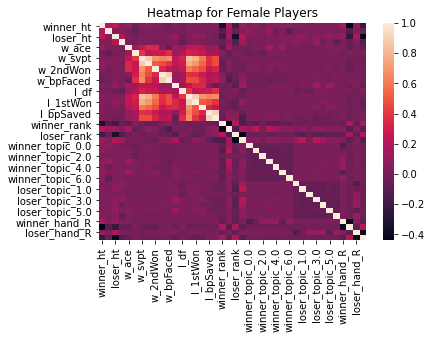

In [13]:
# plotting correlation heatmap
dataplot=sb.heatmap(X_train.corr())

# displaying heatmap
plt.title("Heatmap for Female Players")
plt.show()

In [14]:
def train_models(X_train,y_train, model):
    if model=='KNN':
        clf=KNeighborsClassifier(n_neighbors=7)
        clf.fit(X_train, y_train)
        return clf
    if model=='naive_bayes':
        clf = BernoulliNB()
        clf.fit(X_train, y_train)
        return clf
    if model=="logistic_regression":
        clf = LogisticRegression(random_state=0,solver = "liblinear",C = i, max_iter=1000).fit(X_train, y_train)
        return clf
    if model=='svm':
        clf = svm.SVC()
        clf.fit(X_train, y_train)
        return clf
    if model=='random_forest':
        clf = RandomForestClassifier(max_depth=2, random_state=0)
        clf.fit(X_train, y_train)
        return clf

In [15]:
def evaluate_model(X_val, y_val, model, name):
    y_predict = model.predict(X_val)
    accuracy_score=sklearn.metrics.accuracy_score(y_val, y_predict)
    precision_score = sklearn.metrics.precision_score(y_test,  y_predict, average = 'macro')
    recall = sklearn.metrics.recall_score(y_test,  y_predict, average = 'macro')
    F1_score=sklearn.metrics.f1_score(y_val, y_predict, average='macro')
    roc_auc=sklearn.metrics.roc_auc_score(y_val, y_predict)

    return [name, accuracy_score, precision_score, recall, F1_score, roc_auc]

In [16]:
#acscore = [0]*25
#for i in range(10,35):
#    pca = PCA(n_components=i)
#    principalComponents = pca.fit_transform(X_train)
#    test = pca.transform(X_test)
#    principalDf = pd.DataFrame(data = principalComponents)
#    train=principalDf
#    model = 'logistic_regression'
#    m1 = train_models(train ,y_train, model)
#    y_predict = m1.predict(test)
#    ac_score=sklearn.metrics.accuracy_score(y_test, y_predict)
#    acscore[i-10]=ac_score
#acscore 

In [17]:
#x = [i for i in range(10,35)]
#plt.plot(x,acscore ,'o-',color = 'r',label="WOMEN")#s-:方形
##plt.plot(x,k2,'o-',color = 'g',label="CNN-RLSTM")#o-:圆形
#plt.xlabel("n_components")
#plt.ylabel("ac_score")
#plt.legend(loc = "best")#图例
#plt.show()

In [18]:
pca = PCA(n_components=24)
principalComponents = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2','PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 
                                                                  'PC10','PC11', 'PC12','PC13','PC14','PC15', 'PC16','PC17', 'PC18',
                                                                  'PC19', 'PC20','PC21', 'PC22','PC23', 'PC24'])
X_train=principalDf

In [19]:
#principalComponents

In [20]:
m_list=['KNN','naive_bayes', 'logistic_regression', 'svm', 'random_forest']
scores=[[] for i in range(5)]
for i in range(len(m_list)):
    model = m_list[i]
    m1 = train_models(X_train ,y_train, model)
    score = evaluate_model(X_test, y_test, m1, model)
    scores[i]=score
scores 

D:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[['KNN',
  0.6088570223534374,
  0.6088952351446009,
  0.6088819760656017,
  0.6088511331762224,
  0.6088819760656017],
 ['naive_bayes',
  0.8256431885280472,
  0.8256403560577491,
  0.8256407824013545,
  0.8256405633545939,
  0.8256407824013546],
 ['logistic_regression',
  0.9212146773513286,
  0.9212505461319626,
  0.9212355111914419,
  0.9212144749792842,
  0.9212355111914419],
 ['svm',
  0.6497680303669338,
  0.6497648780126783,
  0.6497478105977497,
  0.6497473926788194,
  0.6497478105977497],
 ['random_forest',
  0.8538169548713623,
  0.8538725093872443,
  0.8538424146109214,
  0.8538156068310051,
  0.8538424146109215]]

In [21]:
head=['model','accuracy_score', 'precision_score', 'recall', 'F1_score', 'roc_auc']
print("Scores for female players with PCA n = 24")
print(tabulate(scores, headers=head))

Scores for female players with PCA n = 24
model                  accuracy_score    precision_score    recall    F1_score    roc_auc
-------------------  ----------------  -----------------  --------  ----------  ---------
KNN                          0.608857           0.608895  0.608882    0.608851   0.608882
naive_bayes                  0.825643           0.82564   0.825641    0.825641   0.825641
logistic_regression          0.921215           0.921251  0.921236    0.921214   0.921236
svm                          0.649768           0.649765  0.649748    0.649747   0.649748
random_forest                0.853817           0.853873  0.853842    0.853816   0.853842


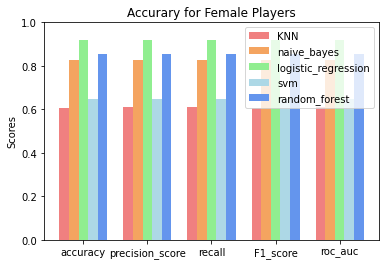

In [22]:
N = 5
ind = np.arange(N) 
width = 0.15
  
xvals = scores[0][1:]
bar1 = plt.bar(ind-width, xvals, width, color = 'lightcoral')
yvals = scores[1][1:]
bar2 = plt.bar(ind, yvals, width, color='sandybrown')
zvals = scores[2][1:]
bar3 = plt.bar(ind+width, zvals, width, color = 'lightgreen')
avals = scores[3][1:]
bar4 = plt.bar(ind+width*2, avals, width, color = 'lightblue')
bvals = scores[4][1:]
bar5 = plt.bar(ind+width*3, bvals, width, color='cornflowerblue')

plt.ylim(0, 1)
plt.ylabel('Scores')
plt.title("Accurary for Female Players")
  
plt.xticks(ind+width,['accuracy', 'precision_score', 'recall', 'F1_score', 'roc_auc'])
plt.legend( (bar1, bar2, bar3, bar4, bar5), ('KNN','naive_bayes', 'logistic_regression', 'svm', 'random_forest') )
plt.show()

In [23]:
men = men.drop(columns=['tourney_id', 'tourney_name', 'winner_ioc', 'winner_name', 'loser_name','loser_ioc', 'best_of', 'round'], axis=1)
w_winner = pd.get_dummies(men, columns=['winner_topic', 'loser_topic', 'surface', 'tourney_level', 'winner_hand', 'loser_hand'])
w_winner.columns

Index(['Unnamed: 0', 'draw_size', 'tourney_date', 'match_num', 'winner_id',
       'winner_ht', 'winner_age', 'loser_id', 'loser_ht', 'loser_age', 'score',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_bpSaved', 'l_bpFaced', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'winner_topic_0.0', 'winner_topic_1.0', 'winner_topic_2.0',
       'winner_topic_3.0', 'winner_topic_4.0', 'winner_topic_5.0',
       'winner_topic_6.0', 'winner_topic_7.0', 'loser_topic_0.0',
       'loser_topic_1.0', 'loser_topic_2.0', 'loser_topic_3.0',
       'loser_topic_4.0', 'loser_topic_5.0', 'loser_topic_6.0',
       'loser_topic_7.0', 'surface_Carpet', 'surface_Clay', 'surface_Grass',
       'surface_Hard', 'tourney_level_A', 'tourney_level_D', 'tourney_level_F',
       'tourney_level_G', 'tourney_level_M', 'winner_hand_L', 'winner_hand_R',
    

In [24]:
w_loser = w_winner.copy()
w_loser.columns = ['Unnamed: 0', 'draw_size', 'tourney_date', 'match_num','loser_id', 'loser_ht', 'loser_age','winner_id',
       'winner_ht', 'winner_age',  'score','l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_bpSaved', 'l_bpFaced',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_bpSaved', 'w_bpFaced',  'loser_rank', 'loser_rank_points', 'winner_rank','winner_rank_points',
       'loser_topic_0.0','loser_topic_1.0', 'loser_topic_2.0', 'loser_topic_3.0',
       'loser_topic_4.0', 'loser_topic_5.0', 'loser_topic_6.0',
       'loser_topic_7.0', 'winner_topic_0.0', 'winner_topic_1.0', 'winner_topic_2.0',
       'winner_topic_3.0', 'winner_topic_4.0', 'winner_topic_5.0',
       'winner_topic_6.0', 'winner_topic_7.0', 'surface_Carpet', 'surface_Clay', 'surface_Grass',
       'surface_Hard', 'tourney_level_A', 'tourney_level_D', 'tourney_level_F',
       'tourney_level_G', 'tourney_level_M', 'loser_hand_L', 'loser_hand_R', 'loser_hand_U', 
       'winner_hand_L', 'winner_hand_R','winner_hand_U']
w_loser['score'] = -w_loser['score']
w_loser = w_loser[['Unnamed: 0', 'draw_size', 'tourney_date', 'match_num', 'winner_id',
       'winner_ht', 'winner_age', 'loser_id', 'loser_ht', 'loser_age', 'score',
       'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn',
       'l_1stWon', 'l_2ndWon', 'l_bpSaved', 'l_bpFaced', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'winner_topic_0.0', 'winner_topic_1.0', 'winner_topic_2.0',
       'winner_topic_3.0', 'winner_topic_4.0', 'winner_topic_5.0',
       'winner_topic_6.0', 'winner_topic_7.0', 'loser_topic_0.0',
       'loser_topic_1.0', 'loser_topic_2.0', 'loser_topic_3.0',
       'loser_topic_4.0', 'loser_topic_5.0', 'loser_topic_6.0',
       'loser_topic_7.0', 'surface_Carpet', 'surface_Clay', 'surface_Grass',
       'surface_Hard', 'tourney_level_A', 'tourney_level_D', 'tourney_level_F',
       'tourney_level_G', 'tourney_level_M', 'winner_hand_L', 'winner_hand_R',
       'winner_hand_U', 'loser_hand_L', 'loser_hand_R', 'loser_hand_U']]
w_winner=pd.concat([w_winner,w_loser],axis=0)
w_winner

,Unnamed: 0,draw_size,tourney_date,match_num,winner_id,winner_ht,winner_age,loser_id,loser_ht,loser_age,...,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,winner_hand_L,winner_hand_R,winner_hand_U,loser_hand_L,loser_hand_R,loser_hand_U
0,0,32,20100103,28,103285,185.0,31.1,104639,180.0,24.1,...,0,0,0,0,0,1,0,1,0,0
1,1,32,20100103,16,103285,185.0,31.1,105357,183.0,20.5,...,0,0,0,0,0,1,0,0,1,0
2,2,32,20100103,17,104053,188.0,27.3,104958,198.0,22.5,...,0,0,0,0,0,1,0,1,0,0
3,3,32,20100103,18,104755,185.0,23.5,105051,188.0,22.1,...,0,0,0,0,0,1,0,0,1,0
4,4,32,20100103,20,105064,188.0,22.0,103248,185.0,31.4,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30665,30665,128,20220829,199,207733,191.0,20.6,111575,198.0,26.2,...,0,0,1,0,1,0,0,0,1,0
30666,30666,128,20220829,198,200282,183.0,23.5,105807,188.0,31.1,...,0,0,1,0,0,1,0,0,1,0
30667,30667,128,20220829,197,200670,183.0,23.6,106401,193.0,27.3,...,0,0,1,0,0,1,0,0,1,0
30668,30668,128,20220829,114,200325,188.0,23.4,207733,191.0,20.6,...,0,0,1,0,0,1,0,1,0,0


In [25]:
scores=w_winner['score']
w_winner=w_winner.drop('score', axis=1)
w_winner['score']=scores
w_winner=w_winner.drop(columns=['tourney_date', 'winner_id', 'loser_id'], axis=1)
w_winner

,Unnamed: 0,draw_size,match_num,winner_ht,winner_age,loser_ht,loser_age,w_ace,w_df,w_svpt,...,tourney_level_F,tourney_level_G,tourney_level_M,winner_hand_L,winner_hand_R,winner_hand_U,loser_hand_L,loser_hand_R,loser_hand_U,score
0,0,32,28,185.0,31.1,180.0,24.1,7.0,4.0,61.0,...,0,0,0,0,1,0,1,0,0,2
1,1,32,16,185.0,31.1,183.0,20.5,3.0,2.0,46.0,...,0,0,0,0,1,0,0,1,0,2
2,2,32,17,188.0,27.3,198.0,22.5,9.0,0.0,59.0,...,0,0,0,0,1,0,1,0,0,2
3,3,32,18,185.0,23.5,188.0,22.1,6.0,2.0,59.0,...,0,0,0,0,1,0,0,1,0,2
4,4,32,20,188.0,22.0,185.0,31.4,7.0,1.0,86.0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30665,30665,128,199,191.0,20.6,198.0,26.2,12.0,8.0,114.0,...,0,1,0,1,0,0,0,1,0,-1
30666,30666,128,198,183.0,23.5,188.0,31.1,9.0,10.0,134.0,...,0,1,0,0,1,0,0,1,0,-1
30667,30667,128,197,183.0,23.6,193.0,27.3,6.0,1.0,80.0,...,0,1,0,0,1,0,0,1,0,-3
30668,30668,128,114,188.0,23.4,191.0,20.6,5.0,3.0,66.0,...,0,1,0,0,1,0,1,0,0,-3


In [26]:
#standardize
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
minmax = preprocessing.MinMaxScaler()
features=['winner_ht', 'loser_ht', 'w_ace',
       'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_bpSaved',
       'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
       'l_2ndWon', 'l_bpSaved', 'l_bpFaced']
#for feature in features:
#    new_data = StandardScaler().fit_transform(w_winner[feature])
#new_data

for feature in features:
    w_winner[feature]= scaler.fit_transform(w_winner[feature].values.reshape(-1,1))
    #test_data[column+'_scaled'] = scaler.fit_transform(test_data[column].values.reshape(-1,1))
w_winner

,Unnamed: 0,draw_size,match_num,winner_ht,winner_age,loser_ht,loser_age,w_ace,w_df,w_svpt,...,tourney_level_F,tourney_level_G,tourney_level_M,winner_hand_L,winner_hand_R,winner_hand_U,loser_hand_L,loser_hand_R,loser_hand_U,score
0,0,32,28,-0.013794,31.1,-0.286883,24.1,0.144257,0.430977,-0.647570,...,0,0,0,0,1,0,1,0,0,2
1,1,32,16,-0.013794,31.1,-0.123030,20.5,-0.584500,-0.403655,-1.155234,...,0,0,0,0,1,0,0,1,0,2
2,2,32,17,0.150059,27.3,0.696236,22.5,0.508636,-1.238286,-0.715258,...,0,0,0,0,1,0,1,0,0,2
3,3,32,18,-0.013794,23.5,0.150059,22.1,-0.037932,-0.403655,-0.715258,...,0,0,0,0,1,0,0,1,0,2
4,4,32,20,0.150059,22.0,-0.013794,31.4,0.144257,-0.820970,0.198537,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30665,30665,128,199,0.313912,20.6,0.696236,26.2,1.055204,2.100240,1.146177,...,0,1,0,1,0,0,0,1,0,-1
30666,30666,128,198,-0.123030,23.5,0.150059,31.1,0.508636,2.934871,1.823063,...,0,1,0,0,1,0,0,1,0,-1
30667,30667,128,197,-0.123030,23.6,0.423147,27.3,-0.037932,-0.820970,-0.004528,...,0,1,0,0,1,0,0,1,0,-3
30668,30668,128,114,0.150059,23.4,0.313912,20.6,-0.220121,0.013661,-0.478348,...,0,1,0,0,1,0,1,0,0,-3


In [27]:
cor_score = w_winner.corr()['score']
cor_score[(cor_score<0.01) & (cor_score>-0.01) ]

Unnamed: 0         0.000000e+00
draw_size          1.418364e-15
match_num          2.303833e-16
winner_age         2.404467e-03
loser_age         -2.404467e-03
surface_Carpet    -7.492979e-17
surface_Clay       1.802254e-17
surface_Grass      2.745211e-17
surface_Hard       1.025456e-15
tourney_level_A    1.814061e-17
tourney_level_D    1.130362e-15
tourney_level_F   -1.976963e-17
tourney_level_G   -2.230673e-16
tourney_level_M   -4.252298e-16
Name: score, dtype: float64

In [28]:
w_winner=w_winner.drop(columns=['Unnamed: 0','draw_size','match_num', 'winner_age','loser_age','surface_Carpet', 'surface_Clay',
                                'surface_Grass','surface_Hard','tourney_level_D','tourney_level_F','tourney_level_G','tourney_level_M',
                                'tourney_level_A'], axis=1)
y = w_winner['score']
w_winner = w_winner.drop(columns =['score'], axis = 1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(w_winner, y, stratify=y, test_size=0.2)

In [30]:
y_train[y_train>0]=1
y_train[y_train<0]=0
y_test[y_test>0]=1
y_test[y_test<0]=0

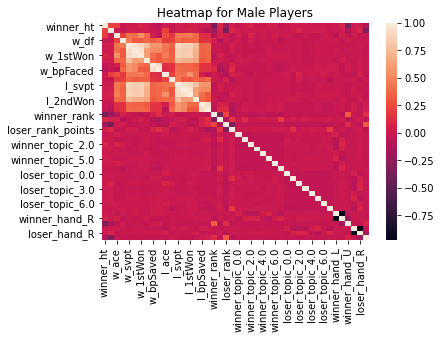

In [31]:
dataplot=sb.heatmap(X_train.corr())

# displaying heatmap
plt.title("Heatmap for Male Players")
plt.show()

In [32]:
#acscore = [0]*25
#for i in range(10,35):
#    pca = PCA(n_components=i)
#    principalComponents = pca.fit_transform(X_train)
#    test = pca.transform(X_test)
#    principalDf = pd.DataFrame(data = principalComponents)
#    train=principalDf
#    model = 'logistic_regression'
#    m1 = train_models(train ,y_train, model)
#    y_predict = m1.predict(test)
#    ac_score=sklearn.metrics.accuracy_score(y_test, y_predict)
#    acscore[i-10]=ac_score
#acscore 

In [33]:
#x = [i for i in range(10,35)]
#plt.plot(x,acscore ,'o-',color = 'b',label="MEN")#s-:方形
##plt.plot(x,k2,'o-',color = 'g',label="CNN-RLSTM")#o-:圆形
#plt.xlabel("n_components")
#plt.ylabel("ac_score")
#plt.legend(loc = "best")#图例
#plt.show()

In [34]:
pca = PCA(n_components=21)
principalComponents = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2','PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 
                                                                  'PC10','PC11', 'PC12','PC13','PC14','PC15', 'PC16','PC17', 'PC18',
                                                                  'PC19', 'PC20', 'PC21'])
X_train=principalDf

In [35]:
m_list=['KNN','naive_bayes', 'logistic_regression', 'svm', 'random_forest']
scores=[[] for i in range(5)]
for i in range(len(m_list)):
    model = m_list[i]
    m1 = train_models(X_train ,y_train, model)
    score = evaluate_model(X_test, y_test, m1, model)
    scores[i]=score
scores 

D:\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:189: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[['KNN',
  0.6182751874796217,
  0.6182710139964179,
  0.6182644852317697,
  0.6182638016307513,
  0.6182644852317698],
 ['naive_bayes',
  0.8095859145745028,
  0.8097264592880028,
  0.8095536574641458,
  0.8095518802723032,
  0.8095536574641456],
 ['logistic_regression',
  0.9294913596348223,
  0.9294907447777991,
  0.9294943404538694,
  0.9294911530327528,
  0.9294943404538694],
 ['svm',
  0.6581349853276818,
  0.6582182451008837,
  0.6580952048858608,
  0.6580529655648941,
  0.6580952048858607],
 ['random_forest',
  0.8289044669057711,
  0.8289192348652636,
  0.8288936648293377,
  0.8288980720626431,
  0.8288936648293376]]

In [36]:
print("Scores for male players with PCA n = 21")
print(tabulate(scores, headers=head))

Scores for male players with PCA n = 21
model                  accuracy_score    precision_score    recall    F1_score    roc_auc
-------------------  ----------------  -----------------  --------  ----------  ---------
KNN                          0.618275           0.618271  0.618264    0.618264   0.618264
naive_bayes                  0.809586           0.809726  0.809554    0.809552   0.809554
logistic_regression          0.929491           0.929491  0.929494    0.929491   0.929494
svm                          0.658135           0.658218  0.658095    0.658053   0.658095
random_forest                0.828904           0.828919  0.828894    0.828898   0.828894


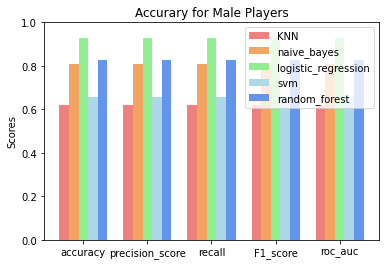

In [37]:
N = 5
ind = np.arange(N) 
width = 0.15
  
xvals = scores[0][1:]
bar1 = plt.bar(ind-width, xvals, width, color = 'lightcoral')
  
yvals = scores[1][1:]
bar2 = plt.bar(ind, yvals, width, color='sandybrown')
  
zvals = scores[2][1:]
bar3 = plt.bar(ind+width, zvals, width, color = 'lightgreen')

avals = scores[3][1:]
bar4 = plt.bar(ind+width*2, avals, width, color = 'lightblue')

bvals = scores[4][1:]
bar5 = plt.bar(ind+width*3, bvals, width, color='cornflowerblue')

plt.ylim(0, 1)
plt.ylabel('Scores')
plt.title("Accurary for Male Players")
  
plt.xticks(ind+width,['accuracy', 'precision_score', 'recall', 'F1_score', 'roc_auc'])
plt.legend( (bar1, bar2, bar3, bar4, bar5), ('KNN','naive_bayes', 'logistic_regression', 'svm', 'random_forest') )
plt.show()